### Load Data

In [1]:
from src.data_load import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
'''
missing data fix strategy
[simple_most_frequent, knn, mice, miwae]
'''

dataset_path = './data/USE-CASE-S2-disadvantaged-students/ULL_dataset.csv'
dataset_dict_path = './data/USE-CASE-S2-disadvantaged-students/ULL_complete_database.xlsx'

dataLoader = DataLoader(dataset_path, dataset_dict_path)

In [29]:
dataset = dataLoader.dataset_3_17

In [30]:
dataset = dataLoader.get_split(dataset, is_level=False, feature_filter=False)
for i in dataset:
    print(i[0], i[1].shape)

score_MAT (3140, 524)
score_LEN (3136, 524)


In [31]:
dataset = dataset[0][1]

In [33]:
from hyperimpute.plugins.imputers import Imputers

imputers = Imputers()

imputers.list()

['missforest',
 'ice',
 'mice',
 'mean',
 'EM',
 'hyperimpute',
 'sklearn_missforest',
 'median',
 'most_frequent',
 'miracle',
 'sinkhorn',
 'softimpute',
 'miwae',
 'nop',
 'gain',
 'sklearn_ice']

### Imputation

In [ ]:
#impyute
dataset = dataLoader.get_imputated(dataset, 'mice')

#transfer int
for column in dataset.columns:
    if dataset[column].dtype == float:
        if (dataset[column].dropna() % 1 == 0).all():
            dataset[column] = dataset[column].astype(int)

In [6]:
dataset.head()

,score_MAT,a1,a2,living_with_father_mother,a3c,a3d,a3et,repeater,a5,a6nm,...,p311b,p311c,p311e,p311f,p311g,p311h,p331b,p331e,p331f,p331g
0,511.0468,2.00000,2008.000000,1.000000,1.000000,2.000000,2.000000,1.000000,4.00,30.441461,...,4.000000,4.000000,4.000000,4.000000,3.000000,4.00000,2.807027,4.000000,2.730660,1.000000
1,281.2682,1.49352,2007.922893,1.324011,1.424625,1.858799,1.972715,1.084243,3.75,25.644687,...,3.333105,3.343739,3.208233,3.374614,3.359177,3.50223,2.807027,3.589911,2.730660,3.004803
2,495.9857,1.00000,2008.000000,2.000000,2.000000,2.000000,2.000000,1.000000,4.00,27.074125,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.00000,1.000000,2.000000,3.000000,3.000000
3,439.4041,2.00000,2008.000000,2.000000,1.000000,2.000000,2.000000,1.000000,4.00,30.000000,...,4.000000,4.000000,4.000000,4.000000,4.000000,4.00000,2.807027,3.877676,3.621372,4.000000
4,447.6379,2.00000,2008.000000,1.000000,1.000000,2.000000,2.000000,1.000000,4.00,60.000000,...,4.000000,3.000000,3.000000,3.000000,3.000000,3.00000,4.000000,4.000000,1.000000,1.000000


### Fair Balance

In [20]:
#metrics
from src.didi_metrics import DIDI
from src.disparate_impact import evaluation_report
#balance
from src.data_fairness import MakeFair

columns = dataset.columns
protected_attributes = [column for column in columns if column in dataLoader.sensitive_features]
target = columns[0]

didi = DIDI(False, protected_attributes)
didi_result_before = didi(dataset, dataset['score_MAT'])
print(f'Before balance DIDI: {didi_result_before}')

Before balance DIDI: 30.26877401056079


In [13]:
# balance dataset
makefair = MakeFair(target, protected_attributes)
final_dataset = makefair.balance(dataset)

Balancing the sensitive attributes...
View Progress: 1 of 4
Sensitive attribute: a1
Combination frequency: [824, 869, 755, 692]
Combination frequency target: 869


View Progress: 2 of 4
Sensitive attribute: repeater
Combination frequency: [1399, 1494, 180, 67]
Combination frequency target: 1494


View Progress: 3 of 4
Sensitive attribute: capital_island
Combination frequency: [1217, 1252, 362, 309]
Combination frequency target: 1252


View Progress: 4 of 4
Sensitive attribute: public_private
Combination frequency: [272, 464, 1307, 1097]
Combination frequency target: 1307




In [14]:
#check for distribution of different groups
target = 'score_binary'
evaluation_report(final_dataset, protected_attributes, target)

,Attribute,Disparate Impact
0,"a1, y=1",1.006331
1,"repeater, y=1",1.007418
2,"capital_island, y=1",1.006955
3,"public_private, y=1",0.988392
4,"a1, y=0",0.993669
5,"repeater, y=0",0.992582
6,"capital_island, y=0",0.993045
7,"public_private, y=0",1.011888


In [21]:
didi = DIDI(False, protected_attributes)
didi_result_after = didi(final_dataset, final_dataset['score_MAT'])
print(f'After balance DIDI: {didi_result_after}')

After balance DIDI: 16.84313672076567


In [16]:
final_dataset = final_dataset.drop(target, axis=1)

### Modeling

In [13]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

In [14]:
def get_train_test(dataset, test_size=0.2, random_state=42):
    train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)
    return train_dataset, test_dataset

#### RandomForest

In [15]:
def random_forest(dataset):
    
    train_dataset, test_dataset = get_train_test(dataset)

    X_train = train_dataset.iloc[:, 1:]
    y_train = train_dataset.iloc[:, 0]

    X_test = test_dataset.iloc[:, 1:]
    y_test = test_dataset.iloc[:, 0]


    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)
    accuracy = mean_absolute_error(y_test, y_pred)
    print(f'MAE: {accuracy}')

    return y_test, y_pred, accuracy

In [23]:
y, p, loss= random_forest(dataset)

MAE: 64.46476212317721


#### Decision Tree

In [21]:
def decision_tree(dataset):
    
    train_dataset, test_dataset = get_train_test(dataset)

    X_train = train_dataset.iloc[:, 1:]
    y_train = train_dataset.iloc[:, 0]

    X_test = test_dataset.iloc[:, 1:]
    y_test = test_dataset.iloc[:, 0]

    dt = DecisionTreeRegressor(random_state=42)
    dt.fit(X_train, y_train)

    y_pred = dt.predict(X_test)
    accuracy = mean_absolute_error(y_test, y_pred)
    print(f'Test Accuracy: {accuracy}')

    return y_test, y_pred, accuracy

In [22]:
y, p, loss = decision_tree(dataset)

Test Accuracy: 93.35505914956669


#### Gradient Boosting Regression (GBR)

In [16]:
def gradient_boosting(dataset):
    
    train_dataset, test_dataset = get_train_test(dataset)

    X_train = train_dataset.iloc[:, 1:]
    y_train = train_dataset.iloc[:, 0]

    X_test = test_dataset.iloc[:, 1:]
    y_test = test_dataset.iloc[:, 0]

    gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
    gb.fit(X_train, y_train)

    y_pred = gb.predict(X_test)
    accuracy = mean_absolute_error(y_test, y_pred)
    print(f'Test Accuracy: {accuracy}')
    
    return y_test, y_pred, accuracy

In [35]:
y, p, loss = gradient_boosting(dataset)

Test Accuracy: 68.77573038589506


#### Lasso Regression

In [37]:
def lasso_regression(dataset):

    train_dataset, test_dataset = get_train_test(dataset)

    X_train = train_dataset.iloc[:, 1:]
    y_train = train_dataset.iloc[:, 0]

    X_test = test_dataset.iloc[:, 1:]
    y_test = test_dataset.iloc[:, 0]

    lasso = Lasso(alpha=0.1)
    lasso.fit(X_train, y_train)

    y_pred = lasso.predict(X_test)
    accuracy = mean_absolute_error(y_test, y_pred)
    print(f'Test Accuracy: {accuracy}')

    return y_test, y_pred, accuracy

In [38]:
y, p, loss = lasso_regression(dataset)

Test Accuracy: 69.53445079269788


### Results

#### Fairness analysis

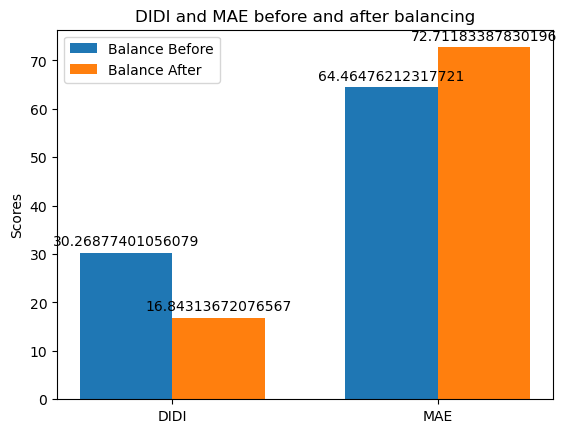

In [25]:
import matplotlib.pyplot as plt
import numpy as np

labels = ['DIDI', 'MAE']
before_balancing = [didi_result_before, loss_before]
after_balancing = [didi_result_after, loss_after]

x = np.arange(len(labels)) 
width = 0.35  

fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, before_balancing, width, label='Balance Before')
bars2 = ax.bar(x + width/2, after_balancing, width, label='Balance After')

ax.set_ylabel('Scores')
ax.set_title('DIDI and MAE before and after balancing')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)

plt.show()



#### Imputation analysis

In [ ]:
imputation_methods = ['simple_most_frequent', 'knn', 'softimpute', 'miwae']

rf_results = []
gbr_results = []

for imp in imputation_methods:
    #impyute
    temp_dataset = dataset.copy()
    temp_dataset = dataLoader.get_imputated(temp_dataset, imp)

    #transfer int
    for column in temp_dataset.columns:
        if temp_dataset[column].dtype == float:
            if (temp_dataset[column].dropna() % 1 == 0).all():
                temp_dataset[column] = temp_dataset[column].astype(int)
                
    accuracy_rf = random_forest(temp_dataset)
    accuracy_gbr = gradient_boosting(temp_dataset)

    rf_results.append(accuracy_rf)
    gbr_results.append(accuracy_gbr)

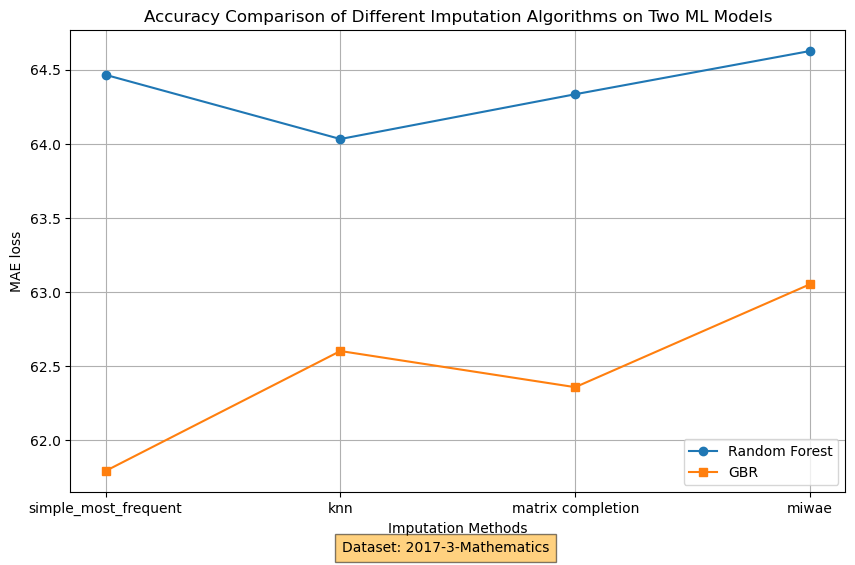

In [39]:
import matplotlib.pyplot as plt

# Imputation methods
algorithms = imputation_methods

# MAE Loss
accuracy_model_a = rf_results
accuracy_model_b = gbr_results 

plt.figure(figsize=(10, 6)) 
plt.plot(algorithms, accuracy_model_a, marker='o', label='Random Forest')
plt.plot(algorithms, accuracy_model_b, marker='s', label='GBR')


plt.title('Accuracy Comparison of Different Imputation Algorithms on Two ML Models')
plt.xlabel('Imputation Methods')
plt.ylabel('MAE loss')


dataset = "2017-3-Mathematics"
plt.figtext(0.5, 0.01, f"Dataset: {dataset}", ha="center", fontsize=10, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})

plt.legend()
plt.grid(True)
plt.show()

#### Model analysis

In [ ]:
didis = []
maes = []
didi_unbalanced = None

methods = [random_forest, decision_tree, gradient_boosting, lasso_regression]

for method in methods:
    y, p, loss, test_dataset = method(dataset)
    maes.append(loss)

    test_dataset['target'] = p
    idi_result = didi(test_dataset, test_dataset['target'])
    didis.append(didi(dataset, p))

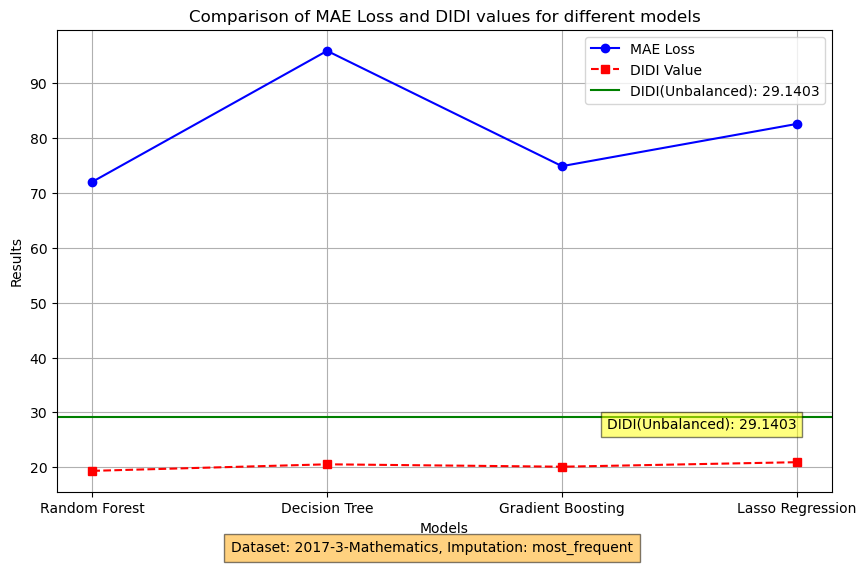

In [23]:
#draw 
plt.figure(figsize=(10, 6))

plt.plot(methods, maes, marker='o', linestyle='-', color='blue', label='MAE Loss')
plt.plot(methods, didis, marker='s', linestyle='--', color='red', label='DIDI Value')


plt.title('Comparison of MAE Loss and DIDI values for different models')
plt.xlabel('Models')
plt.ylabel('Results')

plt.axhline(y=didi_unbalanced, color='green', linestyle='-', label=f'DIDI(Unbalanced): {didi_unbalanced}')

plt.legend()

plt.grid(True)
plt.text(len(methods)-1, didi_unbalanced, f'DIDI(Unbalanced): {didi_unbalanced}', horizontalalignment='right', verticalalignment='top', fontsize=10, bbox=dict(facecolor='yellow', alpha=0.5))


dataset = "2017-3-Mathematics"
plt.figtext(0.5, 0.01, f"Dataset: {dataset}, Imputation: most_frequent", ha="center", fontsize=10, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})

plt.show()

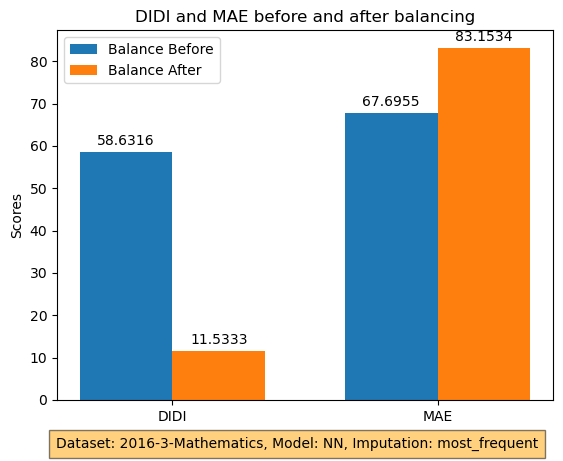

In [24]:
#additional attempt for NN model using GPU

labels = ['DIDI', 'MAE']
before_balancing = [58.6316, 67.6955]
after_balancing = [11.5333, 83.1534]

x = np.arange(len(labels)) 
width = 0.35  

fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, before_balancing, width, label='Balance Before')
bars2 = ax.bar(x + width/2, after_balancing, width, label='Balance After')

ax.set_ylabel('Scores')
ax.set_title('DIDI and MAE before and after balancing')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)


dataset = "2016-3-Mathematics"
algorithm = "NN"
plt.figtext(0.5, 0.01, f"Dataset: {dataset}, Model: {algorithm}, Imputation: most_frequent", ha="center", fontsize=10, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})

plt.show()